In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  # 如果想要更方便地可视化混淆矩阵，可以使用 seaborn
from tqdm import tqdm   # 用于进度条
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

| 方法 | 适用场景 | 优点 | 缺点 |
|------|----------|------|------|
| **方差过滤** | 特征数据较多，但部分特征几乎无变化 | 简单高效 | 可能误删重要特征 |
| **相关性分析** | 需要快速找出与目标变量相关的特征 | 可解释性强 | 仅适用于线性关系 |
| **递归特征消除 (RFE)** | 需要选择固定数量的重要特征 | 适用于各种模型 | 计算量较大 |
| **Lasso (L1 正则化)** | 数据含有冗余特征 | 可自动筛选特征 | 只适用于线性模型 |
| **随机森林特征选择** | 适用于分类问题 | 适用于高维数据 | 计算量大 |
| **LightGBM 重要性** | 数据量大、特征多 | 高效、适用于大规模数据 | 需要调整超参数 |


In [158]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

def rfe_selection(df, target_column, n_features_to_select=5):
    """
    使用RFE（递归特征消除）选择特征
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    n_features_to_select: int - 选择的特征数量（默认5）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(model, n_features_to_select=n_features_to_select)
    selector.fit(X, y)
    
    selected_features = X.columns[selector.support_].tolist()
    return selected_features


In [159]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def lasso_selection(df, target_column, alpha=0.01):
    """
    使用 Lasso 回归进行特征选择
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    alpha: float - Lasso 回归的正则化参数（默认0.01）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled, y)

    selected_features = X.columns[lasso.coef_ != 0].tolist()
    return selected_features


In [160]:
import lightgbm as lgb

def lgbm_feature_selection(df, target_column, num_features=10):
    """
    使用 LightGBM 选择特征
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    num_features: int - 选择的特征数量（默认10）
    
    返回:
    selected_features: list - 选出的特征名列表
    """
    X = df.drop([target_column], axis=1)
    y = df[target_column]

    model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    selected_features = feature_importances.nlargest(num_features).index.tolist()
    return selected_features


In [161]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

def select_features_with_rf(df, target_column, test_size=0.3, n_estimators=100, random_state=42):
    """
    使用随机森林进行特征选择
    
    参数:
    df: DataFrame - 输入数据集
    target_column: str - 目标变量列名
    test_size: float - 测试集比例 (默认 0.3)
    n_estimators: int - 随机森林树的数量 (默认 100)
    random_state: int - 随机种子，确保结果可复现 (默认 42)
    
    返回:
    selected_features: list - 选出的特征名列表
    X_train_selected: DataFrame - 训练集筛选后的特征
    X_test_selected: DataFrame - 测试集筛选后的特征
    y_train: Series - 训练集目标变量
    y_test: Series - 测试集目标变量
    """
    
    # 1. 分离特征和目标变量
    #df = pd.read_csv(train_path)
    #X, y = preprocess_data(df)

    X = df.drop([target_column], axis=1)
    y = df[target_column]

    # 2. 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    #print(f"训练集: {X_train.shape}, 测试集: {X_test.shape}")

    # 3. 训练随机森林模型
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    rf.fit(X_train, y_train)

    # 4. 使用 SelectFromModel 进行特征选择
    sel = SelectFromModel(rf)
    sel.fit(X_train, y_train)

    # 5. 获取被选中的特征
    selected_features = X_train.columns[sel.get_support()].tolist()


    return selected_features

In [162]:
# -----------------------------------------------------------------------------
# 1. 数据预处理函数
# -----------------------------------------------------------------------------
def preprocess_data(df):
    """
    对数据进行预处理：
    1. 将object类型或可能是字符串类型的特征进行编码（标签编码）
    2. 提取特征X和标签y
    """
    # 假设最后一列class为标签
    # 如果列名为 'class'，则：
    if 'class' not in df.columns:
        raise ValueError("DataFrame 中未找到 'class' 列，请检查数据。")
    
    #df = df.drop(columns=['id', 'attack_cat'])  # 删除无用列

    # 版本 1: Label Encoding (适合决策树、随机森林、XGBoost)
    categorical_columns = ['protocol_type', 'service', 'flag']
    df_label = df.copy()
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # 存储编码器，便于逆向转换
    
    print("Label Encoding 完成...")

    # 标准化数值特征（不包括 label）
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_columns.remove('class')  # 不对标签列进行标准化
    
    # 标准化方法
    scaler_standard = StandardScaler()
    scaler_minmax = MinMaxScaler()
    scaler_robust = RobustScaler()

    df_standard = df_label.copy()
    #df_minmax = df_label.copy()
    #df_robust = df_label.copy()

    df_standard[numerical_columns] = scaler_standard.fit_transform(df_standard[numerical_columns])
    
    print("标准化数值特征完成...")
    #df_minmax[numerical_columns] = scaler_minmax.fit_transform(df_minmax[numerical_columns])
    #df_robust[numerical_columns] = scaler_robust.fit_transform(df_robust[numerical_columns])

    #select_features=select_features_with_rf(df_standard, 'label')
    #df_standard=df_standard[select_features+['label']]

    # 分离特征和标签
    #X = df_standard.drop('label', axis=1)
    #y = df_standard['label']

    return df_standard

In [163]:
# 特征选择
def preprocess_data_select(df_standard): 
    
    select_features=select_features_with_rf(df_standard, 'class')
    df_standard=df_standard[select_features+['class']]
    
    return df_standard, select_features

In [164]:
import torch
import torch.nn as nn
# 深度神经网络（DNN）
class DNN_IDS(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNN_IDS, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def create_dnn_model(input_size, hidden_sizes, output_size):
    return DNN_IDS(input_size, hidden_sizes, output_size)
# 输入大小、隐藏层大小和输出大小

In [165]:
import torch
import torch.nn as nn
# 卷积神经网络（CNN）
class CNN_IDS(nn.Module):
    def __init__(self, input_size, output_size=2):
        super(CNN_IDS, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),  # 归一化
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Flatten(),  # 展平
            nn.Linear(64 * input_size, 128),  
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout 防止过拟合
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])  # (batch, channels, features)
        return self.model(x)

def create_cnn_model(input_size, output_size):
    return CNN_IDS(input_size, output_size)

In [166]:
import torch
import torch.nn as nn
# 循环神经网络（RNN）
class RNN_IDS(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN_IDS, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1, x.shape[1])  # 确保输入形状为 (batch, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 初始化 h0
        out, _ = self.rnn(x, h0)  # 前向传播
        out = self.fc(out[:, -1, :])  # 取最后时间步输出
        return out

def create_rnn_model(input_size, hidden_size, output_size, num_layers=1):
    return RNN_IDS(input_size, hidden_size, output_size, num_layers)
#input_size：每个时间步的输入特征的维度。
#hidden_size：隐藏层的大小，即 RNN 的隐状态维度。
#output_size：输出的维度，例如分类任务的类别数。
#num_layers：RNN 层数，默认值为 1。

In [167]:
import torch
import torch.nn as nn
# 长短时记忆网络（LSTM）
class LSTM_IDS(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM_IDS, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1, x.shape[1])  # 确保输入形状正确 (batch, seq_len, input_size)
        
        # 纠正隐藏状态 hx 和 cx 的形状
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # 前向传播
        out = self.fc(out[:, -1, :])  # 取最后时间步的输出
        return out

def create_lstm_model(input_size, hidden_size, output_size, num_layers=1):
    return LSTM_IDS(input_size, hidden_size, output_size, num_layers)
#input_size：每个时间步的输入特征的维度。
#hidden_size：隐藏层的大小，即 LSTM 的隐状态维度。
#output_size：输出的维度，例如分类任务的类别数。
#num_layers：LSTM 层数，默认值为 1。


In [168]:
def vae_loss(recon_x, x, mu, logvar, beta=0.1):  # beta 控制 KL 损失大小
    recon_loss = nn.MSELoss()(recon_x, x)
    kl_divergence = -0.5 * beta * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # 调低 KL 权重
    return recon_loss + kl_divergence


In [169]:
def compute_threshold(model, X_train):
    """
    计算 VAE 的重构误差阈值（均值 + 3 * 标准差）
    """
    model.eval()
    with torch.no_grad():
        recon_x, _, _ = model(X_train)  # VAE 生成重构数据
        mse_loss = torch.mean((X_train - recon_x) ** 2, dim=1)  # 计算 MSE 误差
    
    threshold = mse_loss.mean().item() + 3 * mse_loss.std().item()  # 设定阈值
    print(f"设定 VAE 阈值：{threshold:.6f}")
    return threshold


In [170]:
import torch
import torch.nn as nn
# 变分自编码器（VAE）
class VAE_IDS(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE_IDS, self).__init__()

        # 编码器部分
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)  # 批量归一化
        self.fc21 = nn.Linear(hidden_size, latent_size)  # 均值
        self.fc22 = nn.Linear(hidden_size, latent_size)  # 方差

        # 解码器部分
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.fc4 = nn.Linear(hidden_size, input_size)

        self.dropout = nn.Dropout(0.3)  # 防止过拟合

    def encode(self, x):
        h1 = torch.relu(self.bn1(self.fc1(x)))
        h1 = self.dropout(h1)
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.bn2(self.fc3(z)))
        h3 = self.dropout(h3)
        return self.fc4(h3)  # 不使用 sigmoid，使用 MSELoss 计算损失

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar  

def create_vae_model(input_size, hidden_size, latent_size):
    return VAE_IDS(input_size, hidden_size, latent_size)
#hidden_size：隐藏层的大小。
#latent_size：潜在空间的大小。


In [171]:
import torch
import torch.nn as nn

# 选择模型的函数，根据传入的模型名称返回对应的模型实例
def choose_model(model_name='dnn',input_size=None, **kwargs):
    model_name = model_name.lower()
    
    if model_name == 'dnn':  # 深度神经网络（DNN）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        hidden_sizes = kwargs.get('hidden_sizes', [128, 64])
        output_size = 2  # 入侵检测系统（IDS）是二分类任务
        return DNN_IDS(input_size, hidden_sizes, output_size)
    
    elif model_name == 'cnn':  # 卷积神经网络（CNN）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        return CNN_IDS(input_size,output_size=2)  # 二分类任务
    
    elif model_name == 'rnn':  # 循环神经网络（RNN）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        hidden_size = kwargs.get('hidden_size', 128)
        output_size = 2  # 二分类任务
        num_layers = kwargs.get('num_layers', 1)
        return RNN_IDS(input_size, hidden_size, output_size, num_layers)
    
    elif model_name == 'lstm':  # 长短时记忆网络（LSTM）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        hidden_size = kwargs.get('hidden_size', 128)
        output_size = 2  # 二分类任务
        num_layers = kwargs.get('num_layers', 1)
        return LSTM_IDS(input_size, hidden_size, output_size, num_layers)
    
    elif model_name == 'vae':  # 变分自编码器（VAE）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        hidden_size = kwargs.get('hidden_size', 256)
        latent_size = kwargs.get('latent_size', 64)
        return VAE_IDS(input_size, hidden_size, latent_size)
    
    else:
        raise ValueError(f"Unsupported model name: {model_name}")



In [172]:
# -----------------------------------------------------------------------------
# 3. 训练函数
# -----------------------------------------------------------------------------
def train_model(model, train_path, batch_size=64, epochs=10, lr=0.001):
    """
    使用给定的模型和训练集路径对模型进行训练。
    返回训练好的模型，以及预处理后的训练特征和标签。
    """
    print(f"开始加载训练数据：{train_path}")
    df_train = pd.read_csv(train_path)
    print("开始对训练数据进行预处理...")
    
    df_train = preprocess_data(df_train)
    df_train,select_features= preprocess_data_select(df_train)
    
    # 分离特征和标签
    X_train = df_train.drop('class', axis=1)
    y_train = df_train['class']
    #print(X_train)
    # 将 X_train 和 y_train 转换为 NumPy 数组
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    # 转为 PyTorch 张量
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)

    # 选择损失函数和优化器
    if isinstance(model, VAE_IDS):
        criterion = vae_loss  # VAE 使用自定义损失
    else:
        criterion = nn.CrossEntropyLoss()  # 其他模型使用交叉熵损失

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 损失函数与优化器
    criterion = nn.CrossEntropyLoss()  # 二分类任务
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 训练循环
    print("开始训练模型...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # 使用 tqdm 进度条
        with tqdm(total=len(X_train), desc=f"Epoch {epoch+1}/{epochs}", unit="samples") as pbar:
            # 分批次训练
            for i in range(0, len(X_train), batch_size):
                inputs = X_train[i:i+batch_size]
                labels = y_train[i:i+batch_size]

                optimizer.zero_grad()

                if isinstance(model, VAE_IDS):  
                    outputs, mu, logvar = model(inputs)  # ✅ 解析 VAE 结果
                    loss = vae_loss(outputs, inputs, mu, logvar)  # ✅ 直接调用 vae_loss
                else:
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)  # 其他模型使用 CrossEntropyLoss


                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                # 更新进度条
                pbar.update(len(inputs))

        # 计算并打印每个 epoch 的平均损失
        avg_loss = running_loss / (len(X_train) // batch_size)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    print("训练完成！")
    return model, X_train, y_train, select_features


In [176]:
# -----------------------------------------------------------------------------
# 4. 测试函数
# -----------------------------------------------------------------------------
def test_model(model, test_path, select_features, batch_size=1000, threshold=None):
    """
    使用给定的模型和测试集路径对模型进行测试。
    返回评估指标分数，并可视化混淆矩阵。
    使用批量预测来提升速度，同时保留进度条。
    
    参数:
    - model: 训练好的模型
    - test_path: 测试集CSV文件路径
    - batch_size: 每批预测的数据量大小
    """

    print(f"开始加载测试数据：{test_path}")
    df_test = pd.read_csv(test_path)

    print("开始对测试数据进行预处理...")

    df_test = preprocess_data(df_test)
    #print(df_test.columns)
    #df_test, select_features_test= preprocess_data_select(df_test)
    #print(select_features)

    # 分离特征和标签
    X_test = df_test.drop('class', axis=1)
    y_test = df_test['class']
    X_test = X_test[select_features]

    #print(X_test)
    # 将 X_train 和 y_train 转换为 NumPy 数组
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
    
    # 转换为 PyTorch 张量
    X_test = torch.tensor(X_test, dtype=torch.float32)  # 直接传递 X_test，而不是 X_test.values
    y_test = torch.tensor(y_test, dtype=torch.long)  # 直接传递 y_test


    print("开始预测...")
    # 如果不需要进度条，或对小数据集，直接使用 model.predict(X_test) 即可:
    # y_pred = model.predict(X_test)
    #
    # 下面使用批量预测方式 + tqdm 进度条的写法：
    model.eval()  # 切换到评估模式
    predictions = []

    if isinstance(model, VAE_IDS) and threshold is None:
        threshold = compute_threshold(model, X_train)  # 计算 VAE 阈值
    
    # 批量预测 + tqdm 进度条
    with torch.no_grad():
        with tqdm(total=len(X_test), desc="Predicting", unit="samples") as pbar:
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i+batch_size]

                if isinstance(model, VAE_IDS):  # ✅ 如果是 VAE 模型
                    recon_x, _, _ = model(inputs)  # 只取重构结果
                    mse_loss = torch.mean((inputs - recon_x) ** 2, dim=1)  # 计算 MSE 误差
                    predicted = (mse_loss > threshold).long()  # 设定阈值，判断是否异常
                else:
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)  # 分类模型
                
                predictions.extend(predicted.numpy())

                # 更新进度条
                pbar.update(len(inputs))

    # 计算指标
    acc = accuracy_score(y_test.numpy(), predictions)
    precision = precision_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    recall = recall_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    f1 = f1_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    print(f"\n测试结果：\nAccuracy = {acc:.20f}\nPrecision = {precision:.20f}\nRecall = {recall:.20f}\nF1-Score = {f1:.20f}")

    # 可视化混淆矩阵
    cm = confusion_matrix(y_test.numpy(), predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return acc, precision, recall, f1

In [178]:
# 设置训练集路径
train_csv_path = 'NSL_KDD_train_split.csv'
df_train = pd.read_csv(train_csv_path)
df_train = preprocess_data(df_train)
df_train,select_features= preprocess_data_select(df_train)
input_size = len(select_features)

# 主流程示例
selected_model_name = 'dnn'  # 'dnn', 'cnn', 'rnn', 'lstm', 'vae' 等
model = choose_model(selected_model_name, input_size=input_size)  # 选择模型

# 训练模型
model, X_train, y_train, select_features = train_model(model, train_csv_path, batch_size=64, epochs=10)

#print(select_features)

Label Encoding 完成...
标准化数值特征完成...
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Epoch 1/10: 100%|██████████| 100000/100000 [00:01<00:00, 58485.95samples/s]


Epoch [1/10], Loss: 0.1227


Epoch 2/10: 100%|██████████| 100000/100000 [00:01<00:00, 56004.62samples/s]


Epoch [2/10], Loss: 0.0788


Epoch 3/10: 100%|██████████| 100000/100000 [00:01<00:00, 55669.64samples/s]


Epoch [3/10], Loss: 0.0706


Epoch 4/10: 100%|██████████| 100000/100000 [00:02<00:00, 49087.55samples/s]


Epoch [4/10], Loss: 0.0656


Epoch 5/10: 100%|██████████| 100000/100000 [00:01<00:00, 51124.83samples/s]


Epoch [5/10], Loss: 0.0620


Epoch 6/10: 100%|██████████| 100000/100000 [00:01<00:00, 55562.00samples/s]


Epoch [6/10], Loss: 0.0592


Epoch 7/10: 100%|██████████| 100000/100000 [00:01<00:00, 53686.41samples/s]


Epoch [7/10], Loss: 0.0572


Epoch 8/10: 100%|██████████| 100000/100000 [00:01<00:00, 52142.68samples/s]


Epoch [8/10], Loss: 0.0555


Epoch 9/10: 100%|██████████| 100000/100000 [00:01<00:00, 54718.05samples/s]


Epoch [9/10], Loss: 0.0539


Epoch 10/10: 100%|██████████| 100000/100000 [00:01<00:00, 55785.18samples/s]

Epoch [10/10], Loss: 0.0525
训练完成！


开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1104438.57samples/s]


测试结果：
Accuracy = 0.98479847984798485339
Precision = 0.98978075065031589919
Recall = 0.98211651917404130252
F1-Score = 0.98593374051452897788


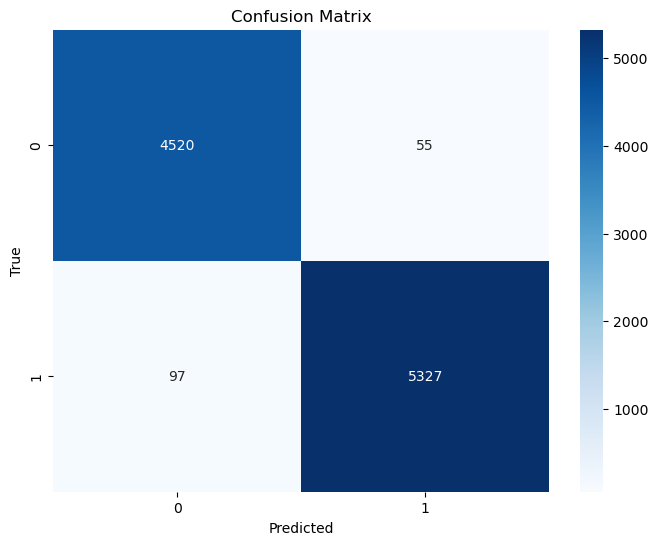

In [179]:
# 测试模型
# 你可以调整batch_size，如1000、5000、甚至一次性预测
#test_csv_path = 'NSL_KDD_PGD_Adversarial.csv'
test_csv_path = 'NSL_KDD_test_split.csv'
acc, precision, recall, f1 = test_model(model, test_csv_path, select_features, batch_size=1000)